# 1. Importer

## 1.1 Les modules nécessaire

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR, LambdaLR
#from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import wandb
from preprocessing import DataPreprocessor, in_out_to_list
from analyse import DataAnalyzer, display_output
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "TVAE.ipynb"
import time
from datetime import datetime, timedelta
import evaluation
import seaborn as sns
import warnings
from typing import Dict, List, Tuple, Union
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.decomposition import PCA
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
"""

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Union, Optional"""
%load_ext autoreload
%autoreload 2

GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.44 GB


## 1.2 Des données

In [5]:
data = pd.read_csv('data/DataModified.csv', sep=',')

param = data.iloc[:, 1:10]  

cat_cols = ["CONFIG", "T", "EQUIPEMENT", "FREQUENCE"]
num_cols = ["DATA", "DELTA", "MESURE A", "MESURE A REF", "MESURE B"] 

num_param = data[num_cols]
cat_param = data[cat_cols]

param[cat_cols] = data[cat_cols].astype('category')  
data.head()


,INPUT,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,OUTPUT
0,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
1,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
2,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
3,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
4,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."


# 2. Visualiser des données initiales 

- **Numériques**

,DATA,DELTA,MESURE A,MESURE A REF,MESURE B
count,6845.000000,6845.000000,6845.000000,6845.000000,6845.000000
mean,91.869978,1.445581,-0.695638,-0.539388,2.623765
std,64.076459,33.623124,0.832821,0.543114,1.768035
min,0.000000,-131.000000,-7.673330,-6.049308,-5.529413
25%,44.000000,-2.000000,-0.913886,-0.817531,1.459265
50%,86.000000,0.000000,-0.593030,-0.711223,2.230435
75%,130.000000,0.000000,-0.068406,-0.121224,3.663460
max,255.000000,208.000000,0.000000,0.000000,11.580734
skewness,0.444388,1.533342,-3.513793,-5.225133,0.341602
kurtosis,-0.346068,10.795778,20.259527,51.546328,2.050591


C:\Users\anhqu\anaconda3\envs\torchenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6845.
  res = hypotest_fun_out(*samples, **kwds)


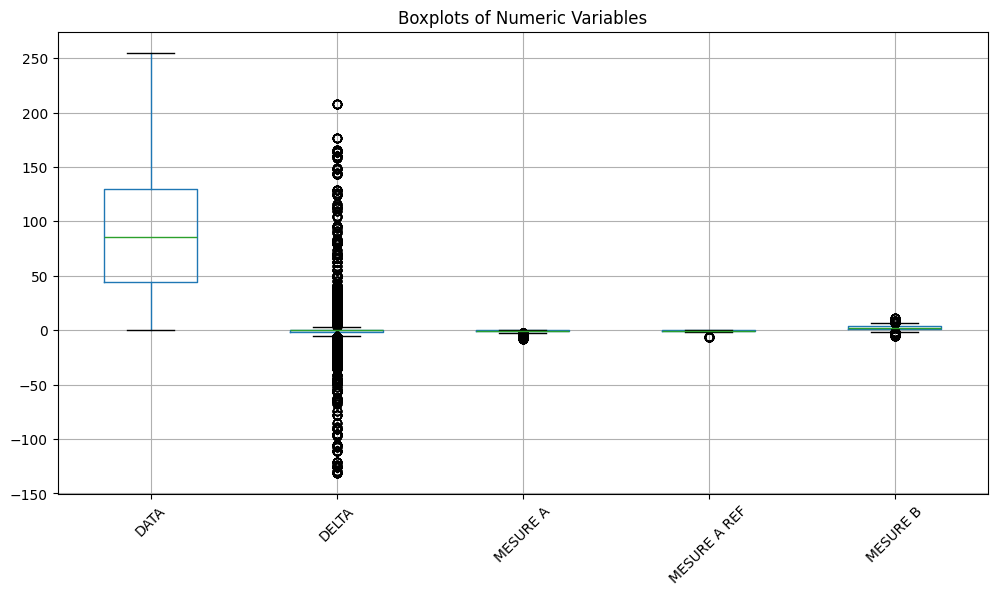

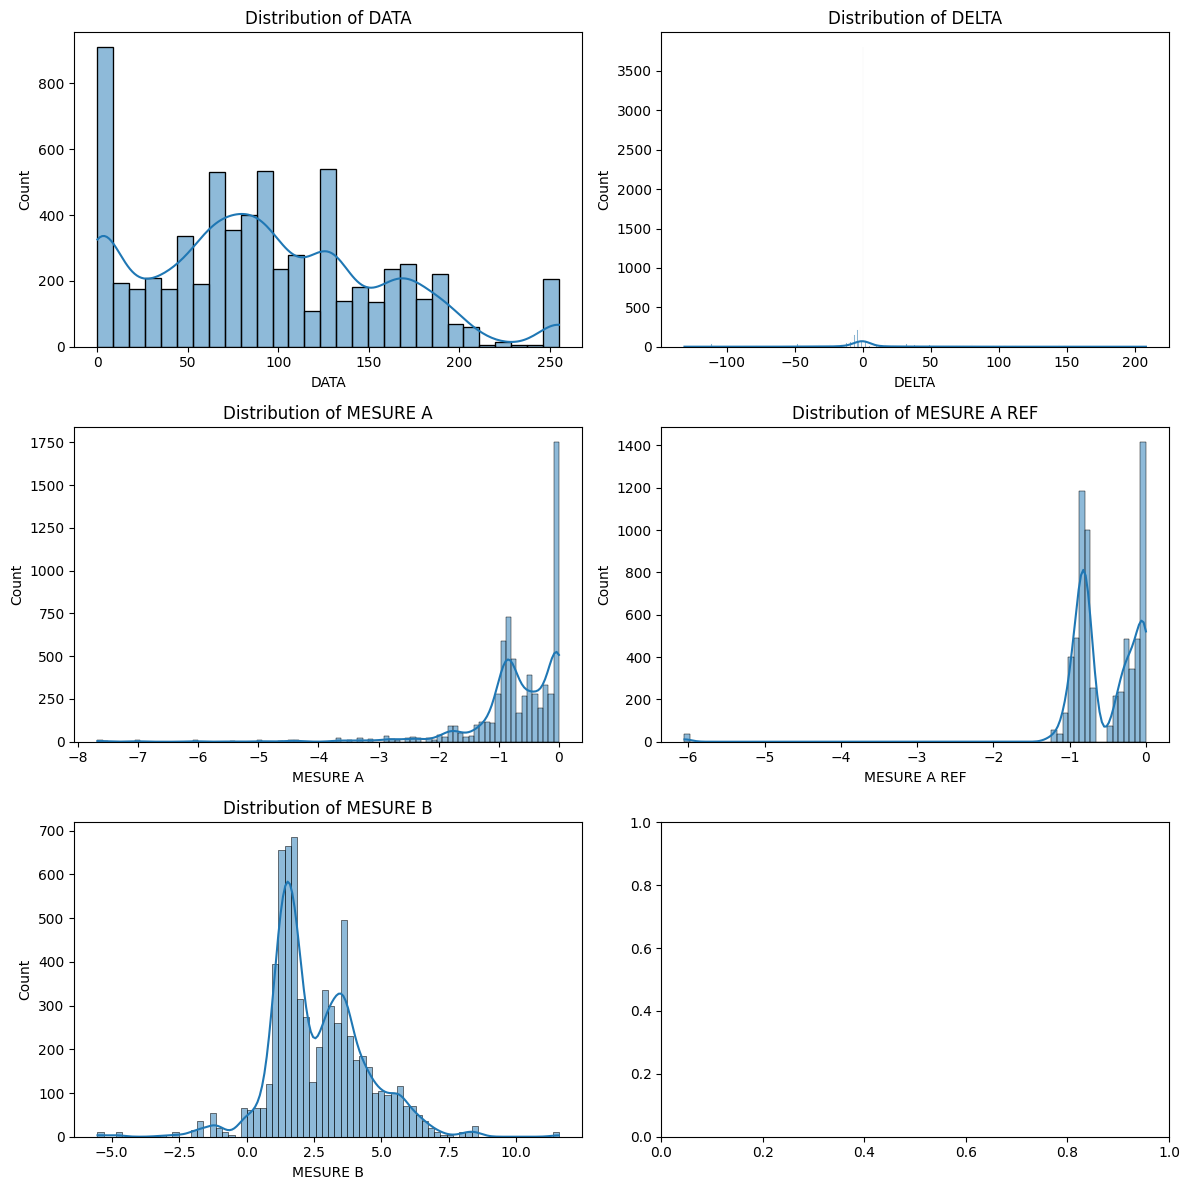

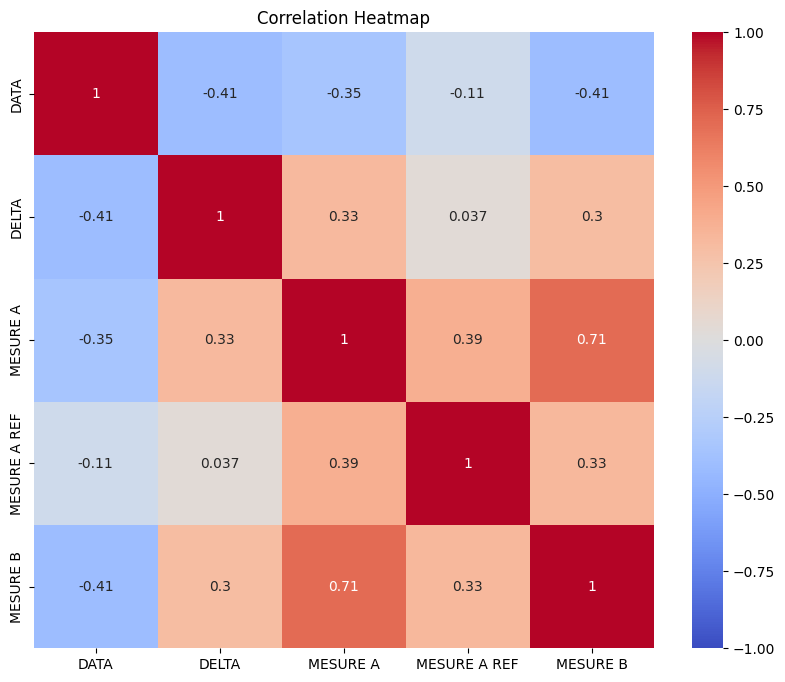

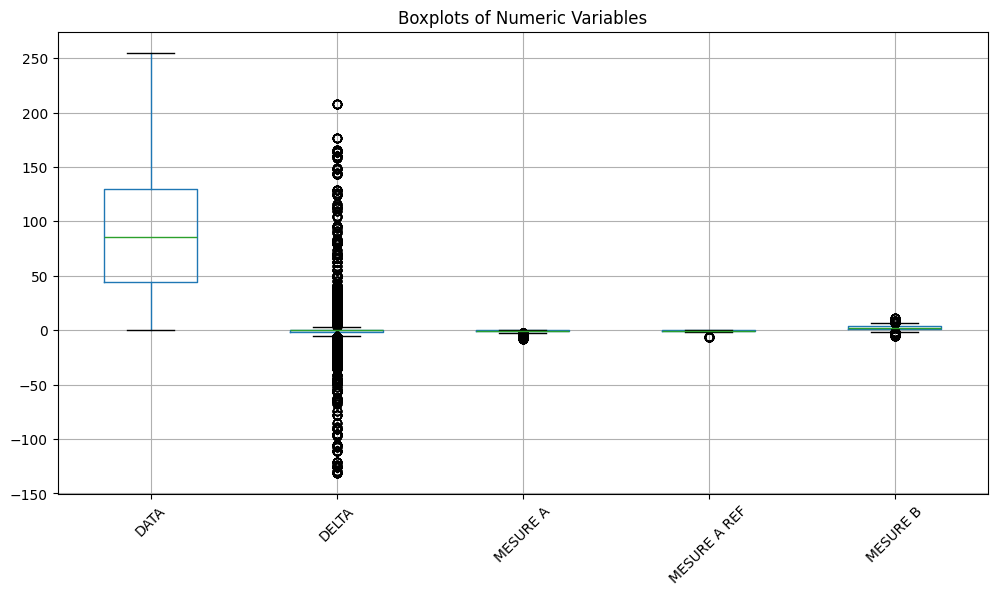

In [8]:
analyzer = DataAnalyzer(data, numeric_columns = num_cols, categorical_columns= cat_cols)

# Get summary statistics
summary_stats = analyzer.get_summary_statistics()
display(summary_stats[0])
# Analyze distributions
distribution_analysis = analyzer.analyze_distributions(param.columns)

# Create visualizations
analyzer.plot_distributions()
analyzer.plot_correlation_heatmap()
analyzer.plot_boxplots()


- **Categories**

,CONFIG,T,EQUIPEMENT,FREQUENCE
count,6845.000000,6845.000000,6845.000000,6845.000000
mean,-0.386413,7.986121,3.462381,3.000000
std,1.011725,5.506275,2.171139,1.414317
min,-2.000000,0.000000,1.000000,1.000000
25%,-2.000000,6.000000,1.000000,2.000000
50%,0.000000,6.000000,3.000000,3.000000
75%,0.500000,11.000000,6.000000,4.000000
max,0.500000,15.000000,7.000000,5.000000


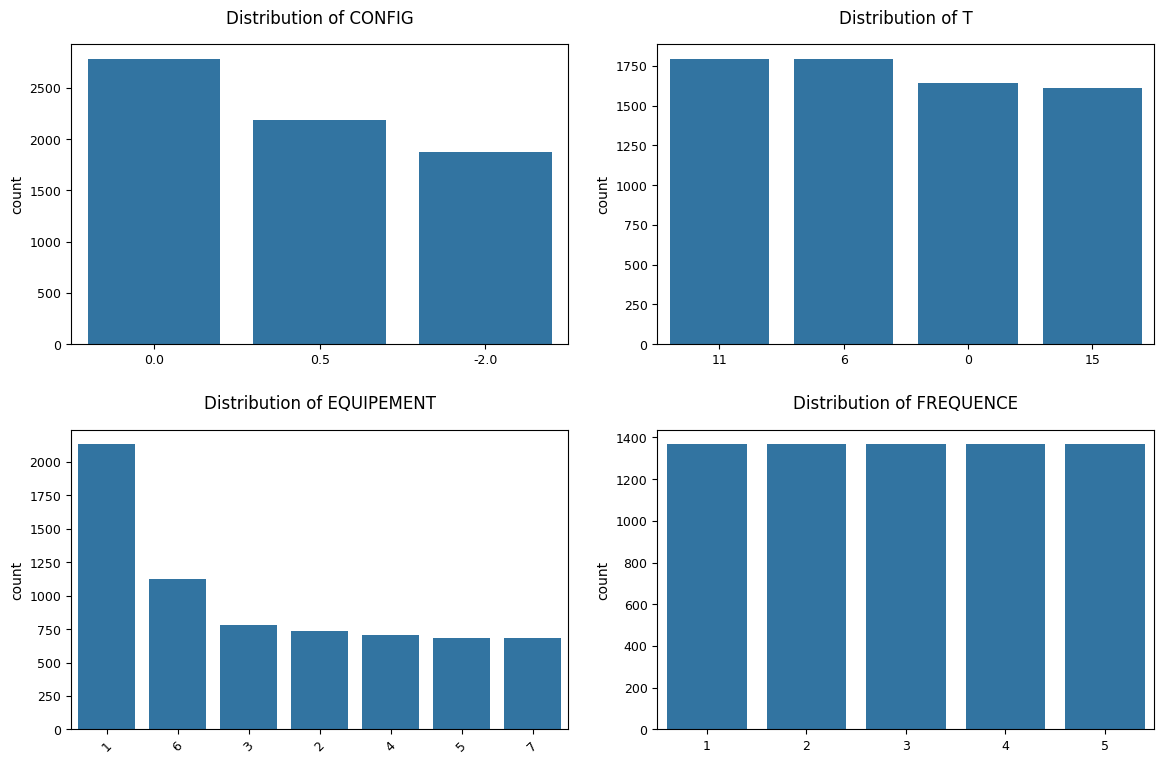

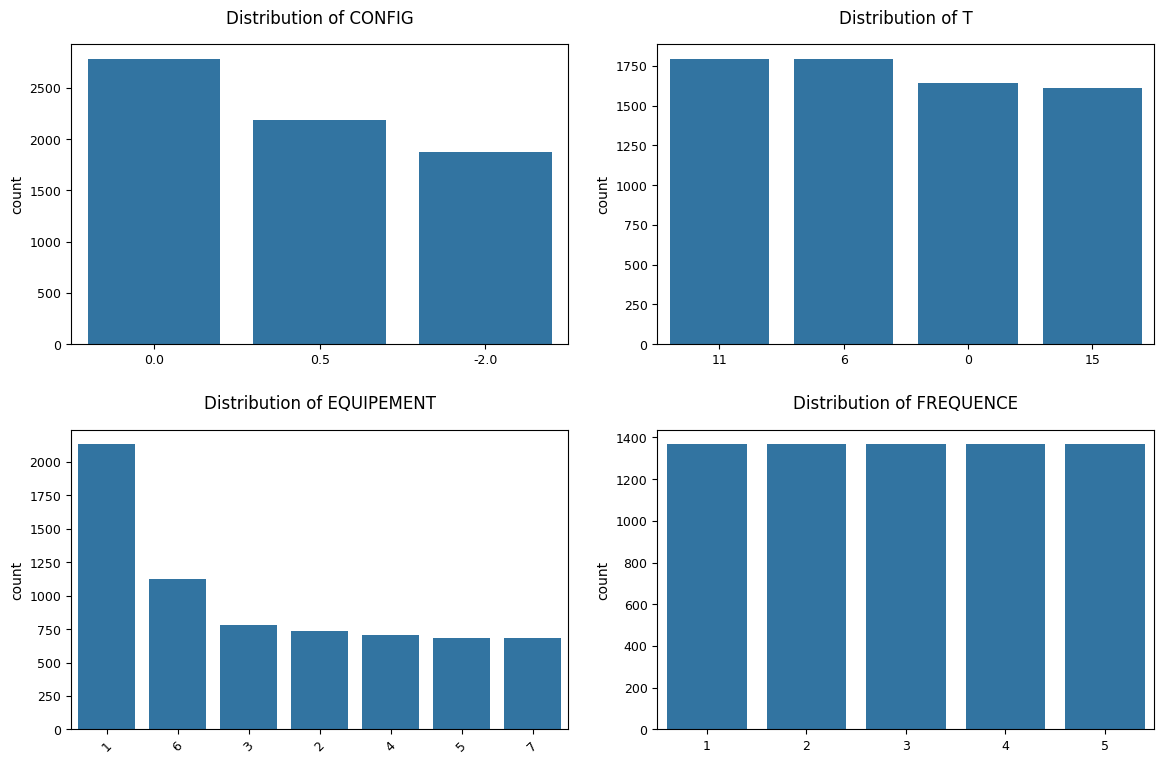

In [10]:
display(summary_stats[1])
analyzer.plot_distributions_cat()

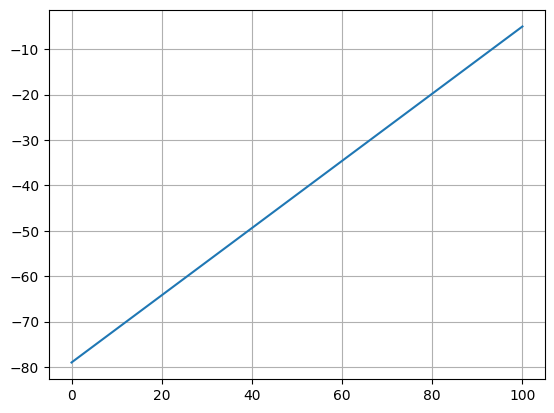

In [11]:
import matplotlib.pyplot as plt
plt.plot(in_out_to_list(data["INPUT"][1]))
plt.grid()

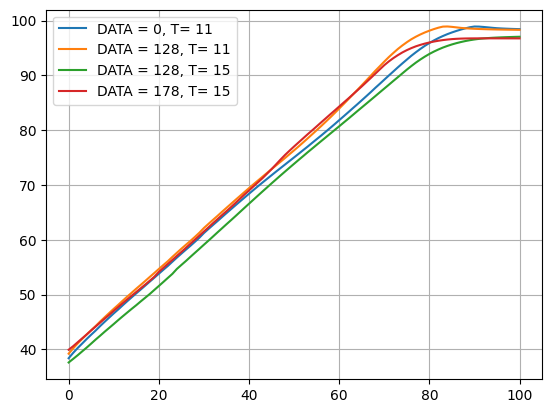

In [12]:
display_output(data,[1,10,200,2000])

# 3. Preprocessing

In [14]:
    
# Create preprocessor
preprocessor = DataPreprocessor(
        data = data,
        categorical_features= cat_cols,
        numerical_features=cat_cols,
        scaling_method='standard',
        categorical_encoding='onehot'
    )
    
    # Preprocess data
#display(preprocessor.get_info())
data['INPUT'] = data['INPUT'].apply(in_out_to_list)
data['OUTPUT'] = data['OUTPUT'].apply(in_out_to_list)
#num = preprocessor.fill_num(num_param)
#preprocessed_data = preprocessor.fit_transform(data)
    
#print("\nOriginal data shape:", data.shape)
#print("Preprocessed data shape:", preprocessed_data.shape)
#print("\nFeature names:", preprocessor.feature_names_out_)
    
    # Inverse transform
#reconstructed_data = preprocessor.inverse_transform(preprocessed_data)
#print("\nReconstructed data sample:")
#print(reconstructed_data.head())
"""dict_output = {}
len_list = len(data['OUTPUT'][0])
n = len(data['INPUT'])
for i in range(len_list):
    list_j = []
    for j in range(n):
        list_j.append(data['OUTPUT'][j][i])
    dict_output[f"out_{i}"] = list_j
df_output = pd.DataFrame(dict_output)
pca = PCA()"""
data['OUTPUT'] = data['OUTPUT'].apply(in_out_to_list)
data = data.join(data['OUTPUT'].apply(pd.Series).add_prefix('OUTPUT_'))
display(data.isnull().sum())

INPUT            0
DATA             0
CONFIG           0
T                0
EQUIPEMENT       0
              ... 
OUTPUT_96     1302
OUTPUT_97     1302
OUTPUT_98     1302
OUTPUT_99     1302
OUTPUT_100    1302
Length: 112, dtype: int64

In [15]:
data

,INPUT,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,...,OUTPUT_91,OUTPUT_92,OUTPUT_93,OUTPUT_94,OUTPUT_95,OUTPUT_96,OUTPUT_97,OUTPUT_98,OUTPUT_99,OUTPUT_100
0,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
1,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
2,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
3,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
4,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",87,-2.0,0,7,-23.0,-1.439788,-1.093460,1.229153,5,...,93.796426,93.792621,93.791216,93.789851,93.788175,93.787142,93.785191,93.784231,93.783424,93.782532
6841,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",64,-2.0,0,7,0.0,-1.093460,-1.093460,1.718189,5,...,93.815747,93.812192,93.809192,93.806491,93.803708,93.801849,93.799915,93.797928,93.796623,93.795923
6842,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.5,0,7,40.0,-0.446849,-0.717651,2.108255,5,...,99.032540,99.006011,98.934013,98.856657,98.833822,98.816301,98.801720,98.790453,98.780231,98.771976
6843,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",20,0.5,0,7,20.0,-0.530118,-0.717651,1.665460,5,...,98.930454,99.039568,98.994188,98.916375,98.851241,98.829302,98.811803,98.797601,98.786556,98.777198


In [16]:
cleaned_data = data.dropna().reset_index(drop=True)
cleaned_data

,INPUT,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,...,OUTPUT_91,OUTPUT_92,OUTPUT_93,OUTPUT_94,OUTPUT_95,OUTPUT_96,OUTPUT_97,OUTPUT_98,OUTPUT_99,OUTPUT_100
0,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
1,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
2,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
3,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
4,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,...,98.903583,98.838952,98.761276,98.678997,98.609290,98.563116,98.524348,98.491222,98.464178,98.440090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5538,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",87,-2.0,0,7,-23.0,-1.439788,-1.093460,1.229153,5,...,93.796426,93.792621,93.791216,93.789851,93.788175,93.787142,93.785191,93.784231,93.783424,93.782532
5539,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",64,-2.0,0,7,0.0,-1.093460,-1.093460,1.718189,5,...,93.815747,93.812192,93.809192,93.806491,93.803708,93.801849,93.799915,93.797928,93.796623,93.795923
5540,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.5,0,7,40.0,-0.446849,-0.717651,2.108255,5,...,99.032540,99.006011,98.934013,98.856657,98.833822,98.816301,98.801720,98.790453,98.780231,98.771976
5541,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",20,0.5,0,7,20.0,-0.530118,-0.717651,1.665460,5,...,98.930454,99.039568,98.994188,98.916375,98.851241,98.829302,98.811803,98.797601,98.786556,98.777198


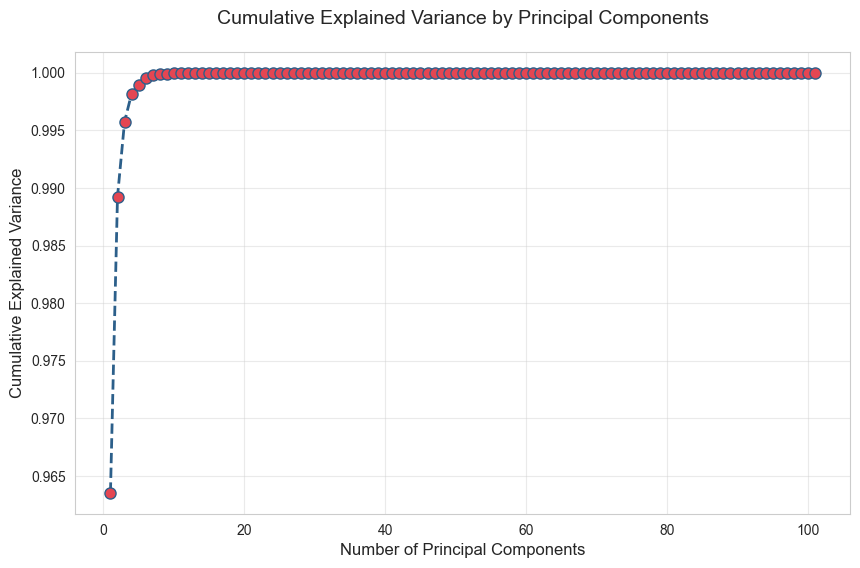

In [17]:
cleaned_output = cleaned_data.iloc[:,11:]
pca_full = PCA()
pca_full.fit(cleaned_output)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Create styled plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot cumulative variance
plt.plot(range(1, len(cumulative_variance)+1), 
         cumulative_variance, 
         marker='o',
         linestyle='--',
         color='#2C5F8A',
         linewidth=2,
         markersize=8,
         markerfacecolor='#E44652')
plt.title('Cumulative Explained Variance by Principal Components', fontsize=14, pad=20)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True, alpha=0.4)



In [18]:
#Select n components
n_components  = 7
print(f"Information kept {100*sum(pca_full.explained_variance_ratio_[:n_components])}%")
pca = PCA(n_components)
output_pca = pca.fit_transform(cleaned_output)
trainable_data = pd.concat([cleaned_data.iloc[:,1:10], pd.DataFrame(data = output_pca, columns= [f"comp_{i}" for i in np.arange(1,n_components+1)])], axis=1)
trainable_data

Information kept 99.97584921575081%


,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7
0,0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,2.558138,1.510088,-6.008367,-1.153421,-0.253999,-1.111852,-0.269794
1,0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,2.558138,1.510088,-6.008367,-1.153421,-0.253999,-1.111852,-0.269794
2,0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,2.558138,1.510088,-6.008367,-1.153421,-0.253999,-1.111852,-0.269794
3,0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,2.558138,1.510088,-6.008367,-1.153421,-0.253999,-1.111852,-0.269794
4,0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,2.558138,1.510088,-6.008367,-1.153421,-0.253999,-1.111852,-0.269794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5538,87,-2.0,0,7,-23.0,-1.439788,-1.093460,1.229153,5,-3.330086,-18.974871,-2.042108,-1.196350,0.288321,0.906314,-1.105805
5539,64,-2.0,0,7,0.0,-1.093460,-1.093460,1.718189,5,-11.743055,-14.477882,-2.126571,-2.229072,0.007280,0.051716,-0.394933
5540,0,0.5,0,7,40.0,-0.446849,-0.717651,2.108255,5,-11.964596,8.011176,-4.182026,0.586743,-0.168137,-1.627055,-0.831631
5541,20,0.5,0,7,20.0,-0.530118,-0.717651,1.665460,5,-22.757390,12.004887,-2.178145,1.841405,-0.115821,-1.742380,-1.261407


In [19]:
trainable_data.describe()

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7
count,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03
mean,94.411690,-0.346202,7.972398,3.462024,1.785134,-0.768081,-0.633058,2.360333,2.647664,-1.411087e-14,6.103771e-14,-1.685921e-14,-2.256098e-14,-1.712071e-14,-5.588970e-14,-6.820210e-15
std,66.956751,0.990403,5.510116,2.182976,37.356440,0.783579,0.560249,1.666710,1.326172,5.645088e+01,9.217862e+00,4.633354e+00,2.840797e+00,1.588347e+00,1.381967e+00,8.885039e-01
min,0.000000,-2.000000,0.000000,1.000000,-131.000000,-7.673330,-6.049308,-5.529413,1.000000,-2.064887e+03,-4.367389e+01,-1.671248e+01,-5.350504e+00,-5.772688e+01,-1.579373e+01,-3.380970e+00
25%,42.000000,-2.000000,6.000000,1.000000,-4.000000,-0.940182,-0.849914,1.358421,2.000000,-6.572154e+00,-5.297434e+00,-2.054760e+00,-1.668067e+00,-1.992240e-01,-1.116089e+00,-4.621244e-01
50%,88.000000,0.000000,6.000000,3.000000,0.000000,-0.764701,-0.773973,1.849031,3.000000,1.514152e+00,1.173013e+00,1.640617e-01,-3.573648e-01,-4.563507e-02,-1.298805e-01,-7.093100e-02
75%,142.000000,0.500000,11.000000,6.000000,0.000000,-0.249562,-0.242806,3.348815,4.000000,9.114449e+00,6.525908e+00,1.907360e+00,1.055987e+00,1.321528e-01,8.644461e-01,4.413504e-01
max,255.000000,0.500000,15.000000,7.000000,208.000000,0.000000,0.000000,11.580734,5.000000,6.569954e+01,2.174483e+01,3.606790e+01,3.610944e+01,5.857085e+01,9.769160e+00,1.266278e+01


In [20]:
output_pca.shape

(5543, 7)

# 4. Générer des données 

## 4.1 TVAE

In [23]:
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data,dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class TVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims : list, latent_dim=32,use_batch_norm=True, dropout_rate = 0.2 , device = 'cpu'):
        super(TVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        self.device = device
        # Encoder
        pre_dim = self.input_dim
        encoder_layers = []
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(pre_dim, dim))
            if use_batch_norm == True:
                encoder_layers.append(nn.BatchNorm1d(dim))
            encoder_layers.extend([nn.LeakyReLU(0.2),
                                   nn.Dropout(dropout_rate),
                                  ])
            pre_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
       
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        pre_dim = latent_dim
        decoder_layers = []
        for dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(pre_dim, dim))
            if use_batch_norm == True:
                decoder_layers.append(nn.BatchNorm1d(dim))
            decoder_layers.extend([nn.LeakyReLU(0.2),
                                   nn.Dropout(dropout_rate),
                                  ])
            pre_dim = dim
        decoder_layers.extend([
            nn.Linear(hidden_dims[0], input_dim),
            nn.Tanh() 
        ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.01)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device = self.device)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
        
    def generate(self, n_samples):
        """Generate synthetic samples from random latent vectors"""
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim, device=self.device)
            return self.decode(z)
            
    def get_reconstruction_loss(self, x_recon, x, mu, log_var, beta=1.0):
        """
        Compute VAE loss with adjustable β-VAE formulation
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        #print(recon_loss.device)
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss with β weighting
        total_loss = recon_loss + beta * kl_loss
        
        return {
            'total_loss': total_loss,
            'reconstruction_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    def interpolate(self, x1, x2, steps=10):
        """Interpolate between two input samples in latent space"""
        with torch.no_grad():
            # Encode both inputs
            mu1, _ = self.encode(x1.unsqueeze(0))
            mu2, _ = self.encode(x2.unsqueeze(0))
            
            # Create interpolation points
            alphas = torch.linspace(0, 1, steps)
            interpolated = []
            
            # Generate intermediate points
            for alpha in alphas:
                z = mu1 * (1 - alpha) + mu2 * alpha
                interpolated.append(self.decode(z))
                
            return torch.cat(interpolated, dim=0)
            
    def compute_metrics(self, x, x_recon):
        """Compute quality metrics for generated samples"""
        with torch.no_grad():
            # Mean absolute error
            mae = F.l1_loss(x_recon, x, reduction='mean')
            
            # Mean squared error
            mse = F.mse_loss(x_recon, x, reduction='mean')
            
            # Cosine similarity
            cos_sim = F.cosine_similarity(x_recon, x).mean()
            
            return {
                'mae': mae.item(),
                'mse': mse.item(),
                'cosine_similarity': cos_sim.item()
            }

def train_tvae(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-2, beta = 1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.2,threshold=1e-4,min_lr=1e-4)
    #scheduler = MultiStepLR(optimizer, milestones=[50,80], gamma=0.1)
    start_time = time.time()
    epoch_times = []
    wandb.init(
    # set the wandb project where this run will be logged
    project="Data Augmentation",
    name="tvae",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "TVAE",
    "dataset": "Physics",
    "epochs": num_epochs,
    }
)
    print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, log_var = model(batch)
            #print(model.device)
            # loss
            loss = model.get_reconstruction_loss(recon_batch,batch, mu, log_var,beta = beta )['total_loss']
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        val_loss = compute_validation_loss(model, val_loader, device, beta = beta)
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        wandb.log({
                "learning_rate": current_lr,  # Track dynamic LR
                "train_loss": total_loss/len(train_loader.dataset),
                "val_loss" : val_loss,
                "epoch": epoch
            })   
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {total_loss/len(train_loader.dataset):.4f}, Val loss: {val_loss}, Learning Rate = {current_lr:.4f}')
            epoch_end = time.time()
            epoch_duration = epoch_end - epoch_start
            epoch_times.append(epoch_duration)
               
    print(f"Training finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    total_duration = time.time() - start_time
    print(f"Total training time: {format_time(total_duration)}")
    wandb.finish()
def generate_synthetic_data(model, n_samples, original_data):
    model.eval()
    with torch.no_grad():
        # Sample from latent space
        z = torch.randn(n_samples, model.fc_mu.out_features)
        # Generate synthetic data
        synthetic_data = model.decode(z)
    return synthetic_data.numpy()

def compute_validation_loss(model, val_loader, device, beta = 1.0):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            batch = batch.to(device)  # Move data to GPU/CPU
            recon_batch, mu, log_var = model(batch)  # Forward pass
            loss_dict = model.get_reconstruction_loss(
                recon_batch, batch, mu, log_var, beta
            )
            total_loss += loss_dict['total_loss'].item()  # Sum losses

    # Average loss over the entire validation set
    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss
def get_unique_values(df, cat_cols):
    """
    Extraire les valeurs uniques pour chaque colonne
    """
    unique_values = {}
    for col in cat_cols:
        unique_values[col] = sorted(df[col].unique())
    return unique_values


def map_to_discrete_values(generated_data, unique_values, cat_cols):
    """
    Mapper les données générées aux valeurs discrètes originales
    """
    result = pd.DataFrame(index=range(len(generated_data)), columns=generated_data.columns)
    
    for col in generated_data.columns:
        # Pour chaque valeur générée, trouver la valeur discrète la plus proche
        if col in cat_cols:
            for i, val in enumerate(generated_data[col]):
                closest_val = min(unique_values[col], key=lambda x: abs(x - val))
                result.loc[i, col] = closest_val
        else:
            result[col] = generated_data[col]
    
    return result

## 4.2. Entrainement 

In [104]:
def format_time(seconds):
    """Convert seconds to a human-readable format"""
    return str(timedelta(seconds=int(seconds)))
def train(save= True):
    # Create sample data
    n_features =  trainable_data.shape[1]
    # Standardize the data
    scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(trainable_data)
    
    # Create dataset and dataloader
    dataset = TabularDataset(scaled_data)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)
    
    
    
    # Initialize and train TVAE
    model = TVAE(input_dim=n_features,latent_dim = 32,hidden_dims=[128,64,64,32,32], device = device) 
    model = model.to(device)

    train_tvae(model, train_loader, val_loader,num_epochs=200, learning_rate=0.07, beta = 0.15)
    #model = model.to('cpu')
    
    is_saved = False
    if save:
        file_name = input("Tap model's name:" )
        while not is_saved:
            if os.path.exists(f"models/{file_name}.pth"):
                print("Model's name existes!!!!")
                file_name = input("Tap model's name:" )
            else:
                torch.save(model,f"models/{file_name}.pth")
                is_saved = True
                print("Done!!!!")
        return 1
train(save = True)


Training started at: 2025-03-11 00:39:37
Epoch [10/200], Train loss: 13.5515, Val loss: 10.011951002803764, Learning Rate = 0.0700
Epoch [20/200], Train loss: 12.9332, Val loss: 9.440110587557767, Learning Rate = 0.0700
Epoch [30/200], Train loss: 12.4458, Val loss: 9.003704487256256, Learning Rate = 0.0700
Epoch [40/200], Train loss: 11.8843, Val loss: 8.405341682399685, Learning Rate = 0.0700
Epoch [50/200], Train loss: 12.2879, Val loss: 8.473390983395795, Learning Rate = 0.0140
Epoch [60/200], Train loss: 11.4780, Val loss: 8.002722200990476, Learning Rate = 0.0140
Epoch [70/200], Train loss: 11.3489, Val loss: 7.911093406574053, Learning Rate = 0.0140
Epoch [80/200], Train loss: 11.2391, Val loss: 7.474756321679159, Learning Rate = 0.0140
Epoch [90/200], Train loss: 11.1009, Val loss: 7.368435556121083, Learning Rate = 0.0140
Epoch [100/200], Train loss: 10.9043, Val loss: 7.10285287896613, Learning Rate = 0.0140
Epoch [110/200], Train loss: 10.6320, Val loss: 6.999447986819488, L

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
learning_rate,███████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
learning_rate,0.0001
train_loss,10.46355
val_loss,6.82545


Tap model's name: best1


Done!!!!


1

- **Note**: Latern space dimention small -> variance small

### 4.3 Generation des données

In [28]:
n_samples = 500

In [112]:
model_name = "best"


original_data = trainable_data
n_features =  original_data.shape[1]

scaler = StandardScaler()
scaler.fit(original_data)

model = torch.load(f"models/{model_name}.pth", weights_only=False)
model = model.to('cpu')

synthetic_data_pre = generate_synthetic_data(model, n_samples, original_data) 

    # Inverse transform the synthetic data
synthetic_data_original_scale = scaler.inverse_transform(synthetic_data_pre)
synthetic_df = pd.DataFrame(
synthetic_data_original_scale,
columns= original_data.columns)

synthetic_data = map_to_discrete_values(synthetic_df, get_unique_values(trainable_data, cat_cols), cat_cols)
#synthetic_data = synthetic_df
    # Convert to DataFrame

print("\nSynthetic Data Sample:")
print(synthetic_data.head())
print("\nSynthetic Data Statistics:")
print(synthetic_data.describe())


Synthetic Data Sample:
         DATA CONFIG   T EQUIPEMENT      DELTA  MESURE A  MESURE A REF  \
0  159.996155    0.0  15          3  -6.470891 -0.915003     -0.834559   
1   46.446777    0.5   6          6   4.658822 -0.745878     -0.810535   
2  160.572906    0.0  15          1 -13.061950 -1.097100     -0.820620   
3  161.361740   -2.0  15          2  -0.595520 -1.060587     -0.920695   
4   59.480797   -2.0   0          4   2.555925 -0.109401     -0.299660   

   MESURE B FREQUENCE    comp_1    comp_2    comp_3    comp_4    comp_5  \
0  1.482024         4 -0.463793  0.899893  1.013472 -0.608208 -0.149619   
1  1.687192         3  1.590556  2.250762 -0.316055 -1.536844 -0.126884   
2  1.159364         2  0.184356  1.597875  2.620270 -1.353443 -0.149904   
3  1.563061         4 -5.701662 -9.213436 -0.544476  1.290147 -0.263395   
4  4.015554         2 -3.083355 -9.216782 -3.640752 -1.351011  0.195470   

     comp_6    comp_7  
0 -1.022479 -0.163466  
1 -0.853877 -0.224060  
2 -0.865

### 4.4 Evaluation


In [114]:
 # Créer l'évaluateur
evaluateur = evaluation.EvaluateurDonneesSynthetiques(original_data, synthetic_data)
    
    # Obtenir le rapport complet
evaluateur.statistiques_basiques()

,DATA_original,DATA_synthetique,CONFIG_original,CONFIG_synthetique,T_original,T_synthetique,EQUIPEMENT_original,EQUIPEMENT_synthetique,DELTA_original,DELTA_synthetique,...,comp_3_original,comp_3_synthetique,comp_4_original,comp_4_synthetique,comp_5_original,comp_5_synthetique,comp_6_original,comp_6_synthetique,comp_7_original,comp_7_synthetique
moyenne,94.411690,98.312752,-0.346202,-0.386,7.972398,8.572,3.462024,3.164,1.785134,0.387541,...,-1.685921e-14,0.012922,-2.256098e-14,-0.058927,-1.712071e-14,0.012454,-5.588970e-14,0.062026,-6.820210e-15,-0.005379
variance,4482.397713,2813.016357,0.980721,1.098004,30.355904,31.132816,4.764524,2.605104,1395.251866,326.050354,...,2.146410e+01,6.754764,8.068673e+00,1.971811,2.522390e+00,0.032856,1.909488e+00,0.889587,7.892968e-01,0.324171
max,255.000000,161.361847,0.500000,0.5,15.000000,15,7.000000,6,208.000000,39.137295,...,3.606790e+01,4.632933,3.610944e+01,2.839995,5.857085e+01,0.842903,9.769160e+00,1.381556,1.266278e+01,0.887369
min,0.000000,27.461288,-2.000000,-2.0,0.000000,0,1.000000,1,-131.000000,-35.567921,...,-1.671248e+01,-4.631608,-5.350504e+00,-2.41884,-5.772688e+01,-0.713414,-1.579373e+01,-1.3393,-3.380970e+00,-0.887451


In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

39888

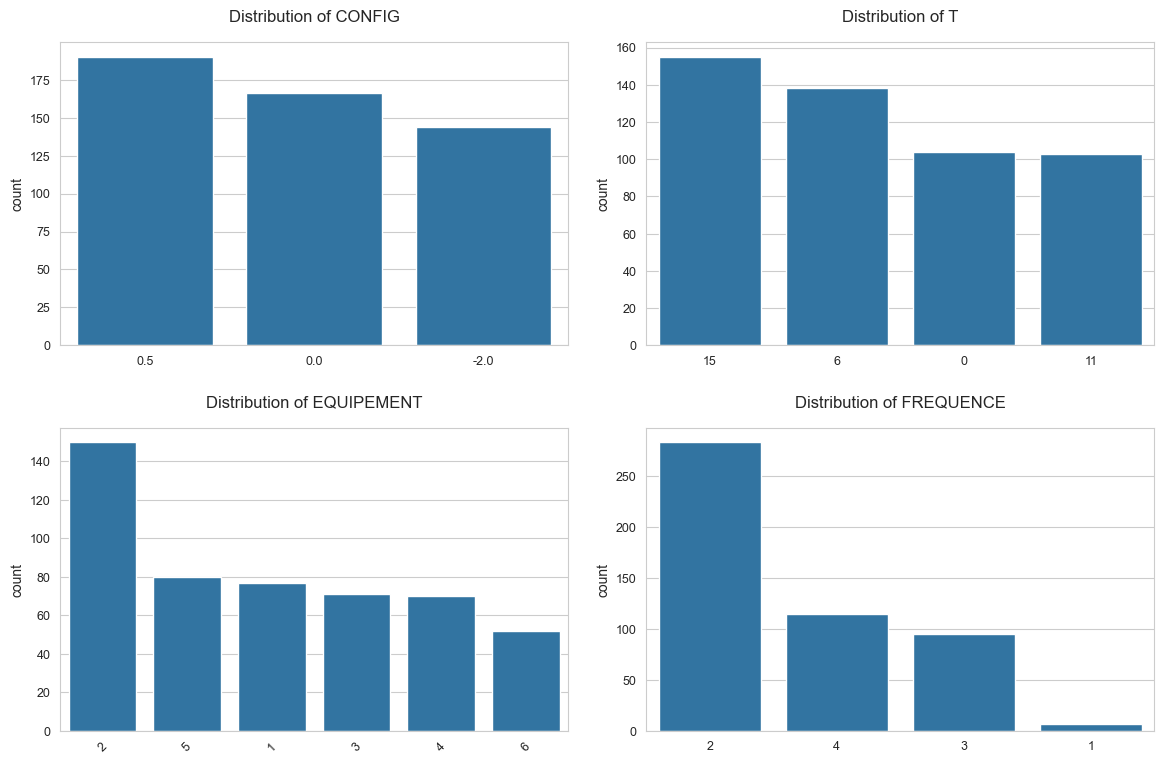

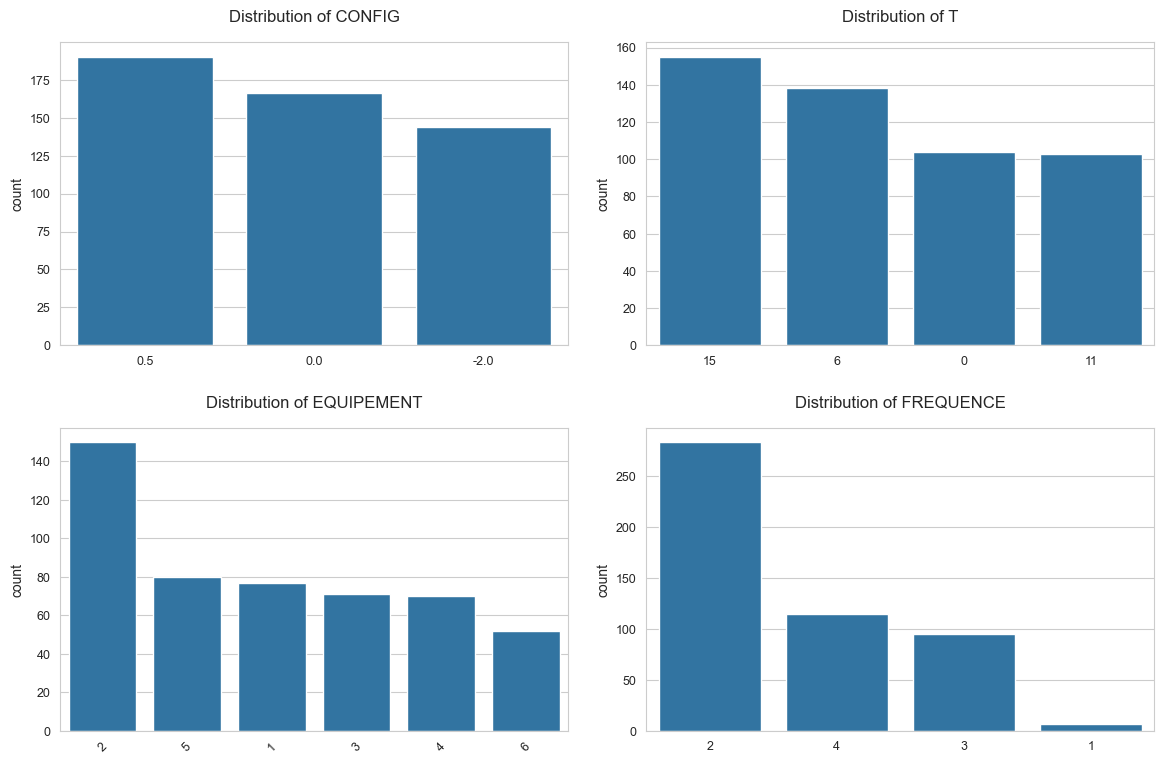

In [116]:
analyzer1 = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
analyzer1.plot_distributions_cat()

In [34]:
synthetic_data.iloc[2,:]

DATA            69.779839
CONFIG                0.0
T                       6
EQUIPEMENT              3
DELTA            4.548534
MESURE A        -0.585284
MESURE A REF    -0.490271
MESURE B           2.7456
FREQUENCE               3
comp_1           3.053977
comp_2           4.049231
comp_3          -0.648117
comp_4           0.482282
comp_5            0.05514
comp_6           0.175201
comp_7          -0.001141
Name: 2, dtype: object

In [35]:
trainable_data.iloc[2,:]

DATA              0.000000
CONFIG            0.000000
T                11.000000
EQUIPEMENT        1.000000
DELTA           144.000000
MESURE A         -0.446507
MESURE A REF     -0.980103
MESURE B          3.214566
FREQUENCE         1.000000
comp_1            2.558138
comp_2            1.510088
comp_3           -6.008367
comp_4           -1.153421
comp_5           -0.253999
comp_6           -1.111852
comp_7           -0.269794
Name: 2, dtype: float64

In [36]:
a = pca.inverse_transform([synthetic_data.iloc[:100,9:]])

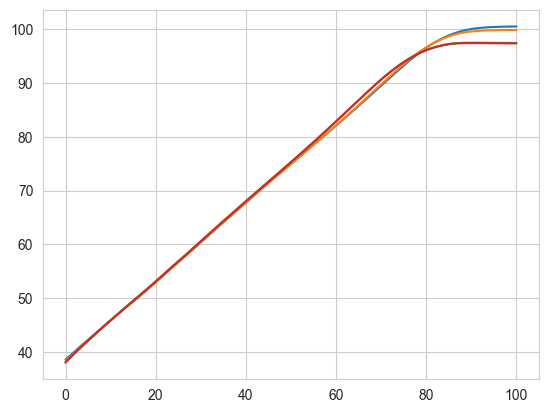

In [37]:
plt.plot(a[0][0])
plt.plot(a[0][10])
plt.plot(a[0][20])
plt.plot(a[0][50])

(array([56., 20., 16., 46., 90., 45., 48., 44., 52., 83.]),
 array([-1.55158901, -1.39535153, -1.23911405, -1.08287644, -0.92663896,
        -0.77040148, -0.61416394, -0.45792639, -0.30168891, -0.14545143,
         0.01078613]),
 <BarContainer object of 10 artists>)

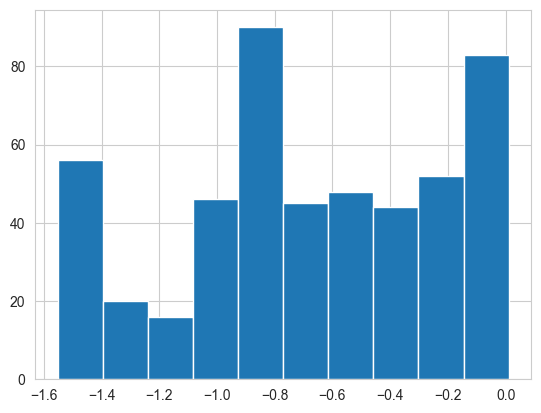

In [132]:
plt.hist(synthetic_data_original_scale[:,5])